*This post has some examples of analysing a genetic cross, using [scikit-allel](http://scikit-allel.readthedocs.org) and general scientific Python libraries ([NumPy](http://www.numpy.org/), [SciPy](https://www.scipy.org/), [pandas](http://pandas.pydata.org/), [matplotlib](http://matplotlib.org/), etc.). As usual, if you spot any errors or have any suggestions, please drop a comment below.*

## Setup

In [1]:
import numpy as np
import scipy
import pandas
import h5py
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.0.3


I'm going to use data from the [Ag1000G](https://www.malariagen.net/ag1000g) project phase 1 data releases ([AR3](https://www.malariagen.net/data/ag1000g-phase1-ar3), [AR3.1](https://www.malariagen.net/data/ag1000g-phase1-ar3.1)), which include genotype calls for four genetic crosses. Each cross involves two parents (a mother and a father) and up to 20 offspring (progeny). These are mosquito crosses, but mosquitoes are diploid (like us), so the genetics are the same as if analysing a cross or family of any other diploid species.

Here's some information about the crosses.

In [2]:
samples = pandas.read_csv('data/phase1.AR3.1/samples/cross.samples.meta.txt', sep='\t')
samples.head()

,ox_code,cross,role,n_reads,median_cov,mean_cov,sex,colony_id
0,AD0231-C,29-2,parent,451.762,20.0,19.375,F,ghana
1,AD0232-C,29-2,parent,572.326,25.0,24.370,M,kisumu
2,AD0234-C,29-2,progeny,489.057,16.0,15.742,F,NaN
3,AD0235-C,29-2,progeny,539.649,17.0,17.364,F,NaN
4,AD0236-C,29-2,progeny,537.237,17.0,17.284,F,NaN


In [3]:
samples.cross.value_counts()

46-9    22
29-2    22
36-9    20
42-4    16
Name: cross, dtype: int64

So there are four crosses. The two largest (crosses '29-2' and '46-9') each have 22 individuals (2 parents, 20 progeny), and the smallest ('42-4') has 16 individuals (2 parents, 14 progeny).

All individuals in all crosses have been sequenced on Illumina HiSeq machines, and then have had genotypes called at variant sites discovered in a cohort of wild specimens. The genotype data were originally in [VCF format](https://samtools.github.io/hts-specs/), however for ease of analysis we've converted the data to [HDF5 format](https://support.hdfgroup.org/HDF5/).

Open the file containing genotype data for chromosome arm 3R.

In [4]:
callset = h5py.File('data/phase1.AR3/variation/crosses/ar3/hdf5/ag1000g.crosses.phase1.ar3sites.3R.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.crosses.phase1.ar3sites.3R.h5" (mode r)>

To analyse your own data using the examples shown below, you would need to convert the genotype data to either NumPy or HDF5 format. If you have the data in VCF format then you can use the [vcfnp](https://github.com/alimanfoo/vcfnp) utility to perform the conversion. There is some documentation in the [vcfnp README](https://github.com/alimanfoo/vcfnp/blob/master/README.rst) but please feel free to email me if you run into any difficulty. This data conversion is the slow, painful step, if you can get over it then the rest should be relatively plain sailing.

Here I am going to start from unphased genotype data. If you have already phased the data that's fine, convert to NumPy or HDF5 as you would for unphased data.

In total I have genotype calls in 80 individuals at 22,632,425 SNPs on chromosome 3R. However, I'm only going to analyse data for a single cross, '29-2', between a mother from the 'Ghana' colony and a father from the 'Kisumu' colony. I can subset out the genotype data for just this cross, and keep only SNPs that are segregating in this cross. I'm also only going to keep SNPs that passed all quality filters.

In [5]:
genotypes = allel.GenotypeChunkedArray(callset['3R/calldata/genotype'])
genotypes

<GenotypeChunkedArray shape=(22632425, 80, 2) dtype=int8 chunks=(6553, 10, 2)
   nbytes=3.4G cbytes=131.6M cratio=26.2
   compression=gzip compression_opts=1
   values=h5py._hl.dataset.Dataset>

In [6]:
# locate the indices of the samples within the callset
sample_indices = samples[samples.cross == '29-2'].index.values.tolist()
sample_indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [7]:
# do an allele count to find segregating variants
ac = genotypes.count_alleles(max_allele=3, subpop=sample_indices)[:]
ac

<AlleleCountsArray shape=(22632425, 4) dtype=int32>
19 25  0  0
44  0  0  0
44  0  0  0
...
0 0 0 0
0 0 0 0
0 0 0 0

In [8]:
# locate segregating SNPs
loc_seg = ac.is_segregating()
loc_seg

array([ True, False, False, ..., False, False, False], dtype=bool)

In [9]:
# how many SNPs are segregating within the cross?
np.count_nonzero(loc_seg)

2142258

In [10]:
# locate SNPs that passed all quality filters
loc_pass = callset['3R/variants/FILTER_PASS'][:]
loc_pass

array([False, False, False, ..., False, False, False], dtype=bool)

In [11]:
# perform the subset and load the results into memory uncompressed
genotypes_cross_pass = genotypes.subset(loc_seg & loc_pass, sample_indices)[:]
genotypes_cross_pass

<GenotypeArray shape=(709399, 22, 2) dtype=int8>
./. 0/0 0/1 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
./. 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0/1 0/0 0/1 0/1 0/0 ... 0/0 0/0 0/0 0/0 0/0
...
1/1 0/0 0/1 0/1 0/1 ... 0/1 0/1 0/1 0/1 0/1
0/0 1/1 0/1 0/1 0/1 ... 0/1 0/1 0/1 0/1 0/1
0/0 1/1 0/1 0/1 0/1 ... 0/1 0/1 0/1 0/1 0/1

Now I have an array of genotype calls at 709,399 segregating SNPs in 22 individuals. The mother is the first column, the father is the second column, and the progeny are the remaining columns. You'll notice that the mother's genotype call is missing at the first two SNPs: we could remove these now, but we'll leave them in for the moment, just to check that phasing is robust to some missing data.

## Phasing by transmission

I'm starting from unphased genotype calls, so the first thing to do is phase the calls to generate haplotypes. There are several options for phasing a cross. Here I'm going to use the [`phase_by_transmission()`](http://scikit-allel.readthedocs.io/en/latest/stats/mendel.html#allel.stats.mendel.phase_by_transmission) function from scikit-allel, because it's convenient and fast (couple of seconds). We've found this function works well for crosses with relatively large numbers of progeny. However, if you have a smaller family with only a couple of progeny, and/or you have a more complicated pedigree with multiple generations, try phasing with [SHAPEIT2 + duoHMM](https://mathgen.stats.ox.ac.uk/genetics_software/duohmm/duohmm.html) or [MERLIN](http://csg.sph.umich.edu/abecasis/merlin/index.html).

In [12]:
genotypes_cross_phased = allel.phase_by_transmission(genotypes_cross_pass, window_size=100)
genotypes_cross_phased

<GenotypeArray shape=(709399, 22, 2) dtype=int8>
./. 0/0 0/1 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
./. 0/0 0/0 0/0 0/0 ... 0/0 0/0 0/0 0/0 0/0
0|1 0|0 1|0 1|0 0|0 ... 0|0 0|0 0|0 0|0 0|0
...
1|1 0|0 1|0 1|0 1|0 ... 1|0 1|0 1|0 1|0 1|0
0|0 1|1 0|1 0|1 0|1 ... 0|1 0|1 0|1 0|1 0|1
0|0 1|1 0|1 0|1 0|1 ... 0|1 0|1 0|1 0|1 0|1

Notice that most of the genotype calls in the snippet shown above now have a pipe character ('`|`') as the allele separator, indicating the call is phased. The first two SNPs could not be phased, however, because the genotype call for one of the parents is missing.

Before we go further, let's subset down to the SNPs where all individuals could be phased.

In [13]:
# locate variants where all genotype calls were phased
loc_phased_all = np.all(genotypes_cross_phased.is_phased, axis=1)
loc_phased_all

array([False, False,  True, ...,  True,  True,  True], dtype=bool)

In [14]:
genotypes_cross_phased_all = genotypes_cross_phased[loc_phased_all]
genotypes_cross_phased_all

<GenotypeArray shape=(629086, 22, 2) dtype=int8>
0|1 0|0 1|0 1|0 0|0 ... 0|0 0|0 0|0 0|0 0|0
0|1 0|0 1|0 1|0 0|0 ... 0|0 0|0 1|0 0|0 0|0
0|2 0|0 2|0 2|0 0|0 ... 2|0 0|0 2|0 0|0 0|0
...
1|1 0|0 1|0 1|0 1|0 ... 1|0 1|0 1|0 1|0 1|0
0|0 1|1 0|1 0|1 0|1 ... 0|1 0|1 0|1 0|1 0|1
0|0 1|1 0|1 0|1 0|1 ... 0|1 0|1 0|1 0|1 0|1

Note we have a few SNPs here which have a "`0|2`" or "`2|0`" genotype call. These were multi-allelic in the original callset.

## Visualising transmission and recombination

Now we have phased data, let's plot the transmission of alleles from parents to progeny. This is a useful diagnostic for assessing the quality of the phasing, and also gives an indication of how much recombination has occurred.

Before plotting, I'm going to separate out the data into maternal and paternal haplotypes. The maternal haplotypes are the two haplotypes carried by the mother, and the haplotype in each of the progeny inherited from the mother. The paternal haplotypes are the same but for the father.

In [15]:
# pull out mother's genotypes from the first column
genotypes_mother = genotypes_cross_phased_all[:, 0]
# convert to haplotype array
haplotypes_mother = genotypes_mother.to_haplotypes()
# pull out maternal haplotypes from the progeny
haplotypes_progeny_maternal = allel.HaplotypeArray(genotypes_cross_phased_all[:, 2:, 0])
# stack mother's haplotypes alongside haplotypes she transmitted to her progeny
haplotypes_maternal = haplotypes_mother.concatenate(haplotypes_progeny_maternal, axis=1)
haplotypes_maternal

<HaplotypeArray shape=(629086, 22) dtype=int8>
0 1 1 1 0 ... 0 0 0 0 0
0 1 1 1 0 ... 0 0 1 0 0
0 2 2 2 0 ... 2 0 2 0 0
...
1 1 1 1 1 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

Let's fix on the mother for a moment. The mother has two haplotypes (displayed in the first two column above). Because recombination occurs during gamete formation, each haplotype the mother passes on to her progeny is a unique mosaic of her own two haplotypes. For any SNP where the mother's two haplotypes carry a different allele, we can "paint" the maternal haplotypes within the progeny according to which of the mother's two alleles were inherited, using the [`paint_transmission()`](http://scikit-allel.readthedocs.io/en/latest/stats/mendel.html#allel.stats.mendel.paint_transmission) function.

In [16]:
painting_maternal = allel.paint_transmission(haplotypes_mother, haplotypes_progeny_maternal)
painting_maternal

array([[2, 2, 1, ..., 1, 1, 1],
       [2, 2, 1, ..., 2, 1, 1],
       [2, 2, 1, ..., 2, 1, 1],
       ..., 
       [4, 4, 4, ..., 4, 4, 4],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=uint8)

This new "painting" array is an array of integer codes, where each number means something. The meanings are given in the help text for the [`paint_transmission()`](http://scikit-allel.readthedocs.io/en/latest/stats/mendel.html#allel.stats.mendel.paint_transmission) function:

In [17]:
help(allel.paint_transmission)

Help on function paint_transmission in module allel.stats.mendel:

paint_transmission(parent_haplotypes, progeny_haplotypes)
    Paint haplotypes inherited from a single diploid parent according to
    their allelic inheritance.
    
    Parameters
    ----------
    parent_haplotypes : array_like, int, shape (n_variants, 2)
        Both haplotypes from a single diploid parent.
    progeny_haplotypes : array_like, int, shape (n_variants, n_progeny)
        Haplotypes found in progeny of the given parent, inherited from the
        given parent. I.e., haplotypes from gametes of the given parent.
    
    Returns
    -------
    painting : ndarray, uint8, shape (n_variants, n_progeny)
        An array of integers coded as follows: 1 = allele inherited from
        first parental haplotype; 2 = allele inherited from second parental
        haplotype; 3 = reference allele, also carried by both parental
        haplotypes; 4 = non-reference allele, also carried by both parental
        hapl

We are particularly interested in plotting the "1" and "2" values, because these occur where the mother's haplotypes carried two different alleles, and so we have information about which allele has been transmitted.

We can do the same for the father.

In [18]:
genotypes_father = genotypes_cross_phased_all[:, 1]
haplotypes_father = genotypes_father.to_haplotypes()
haplotypes_progeny_paternal = allel.HaplotypeArray(genotypes_cross_phased_all[:, 2:, 1])
haplotypes_paternal = haplotypes_father.concatenate(haplotypes_progeny_paternal, axis=1)
haplotypes_paternal

<HaplotypeArray shape=(629086, 22) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
1 1 1 1 1 ... 1 1 1 1 1

In [19]:
painting_paternal = allel.paint_transmission(haplotypes_father, haplotypes_progeny_paternal)
painting_paternal

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ..., 
       [3, 3, 3, ..., 3, 3, 3],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=uint8)

Now we have these "paintings", we can plot them.

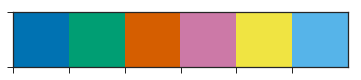

In [20]:
# create a colour palette
palette = sns.color_palette('colorblind')
sns.palplot(palette)

In [21]:
def plot_transmission(painting, title=None):
    
    # set figure height depending on number of haplotypes
    fig, ax = plt.subplots(figsize=(12, .2 * painting.shape[1]))
    
    # map painting codes onto colours
    cmap = mpl.colors.ListedColormap([
        'grey',      # 0 = undetermined
        palette[0],  # 1 = allele inherited from first parental haplotype
        palette[2],  # 2 = allele inherited from second parental haplotype
        palette[1],  # 3 = reference allele, also carried by both parental haplotypes
        palette[3],  # 4 = non-reference allele, also carried by both parental haplotypes
        'black',     # 5 = non-parental allele (i.e., Mendelian error)
        palette[5],  # 6 = either or both parental alleles missing
        'white',     # 7 = missing allele
    ])
    
    # plot painting
    ax.pcolormesh(painting.T, cmap=cmap, vmin=0, vmax=7)
    
    # tidy up axes
    ax.set_yticks(np.arange(painting.shape[1]) + .5)
    ax.set_yticklabels(range(painting.shape[1]))
    ax.set_ylabel('Progeny haplotypes')
    ax.set_xlabel('Variants')
    if title:
        ax.set_title(title)

Run the plot on the maternal progeny haplotypes. I'll plot only every 10th variant as there are >600,000 SNPs here which is way more that can be visualised and slows down plotting.

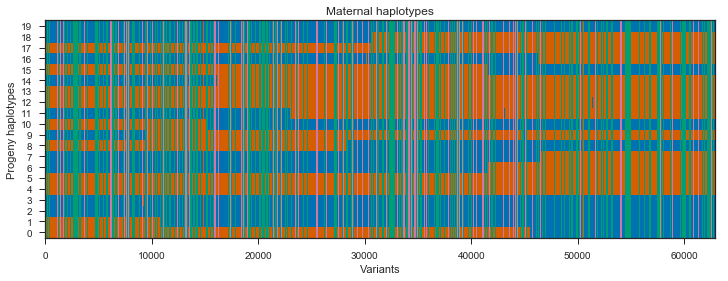

In [22]:
plot_transmission(painting_maternal[::10], title='Maternal haplotypes')

Recombination events can be seen in the switches between blue and red within a single progeny haplotype. However, there are quite a few sites here that do not segregate between the mother's two haplotypes, shown in green and pink. These aren't really interesting, so we can get rid of them by subsetting the painting to only sites that are heterozygous in the mother.

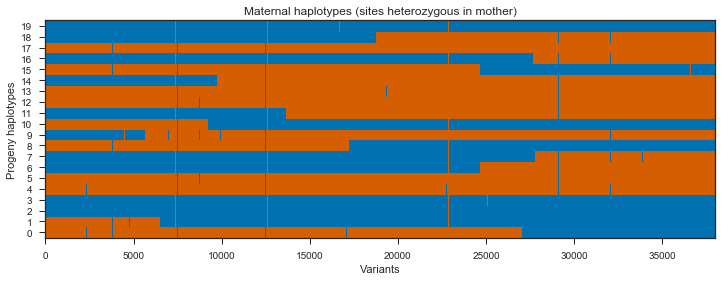

In [23]:
plot_transmission(painting_maternal[genotypes_mother.is_het()][::10], 
                  title='Maternal haplotypes (sites heterozygous in mother)')

Note that there are some SNPs where all progeny are blue, and some SNPs where all progeny are red. These are unlikely to be true as they would imply recombination in multiple progeny at the same location. It's more likely these are genotyping errors in the parent. 

There are also some sites where a single progeny switches from blue to red then straight back to blue, or vice versa. It is possible these are gene conversion events, however they may also be genotyping errors in the progeny.

Let's take a look at the paternal haplotypes.

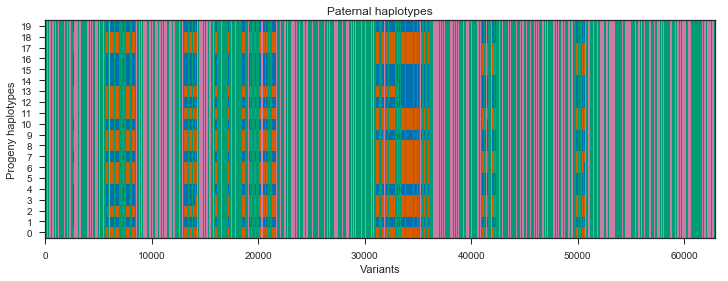

In [24]:
plot_transmission(painting_paternal[::10], title='Paternal haplotypes')

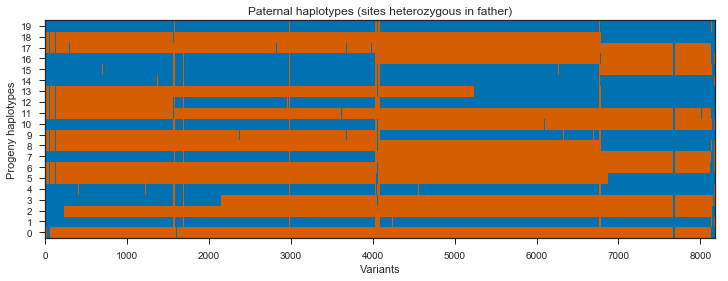

In [25]:
plot_transmission(painting_paternal[genotypes_father.is_het()][::10], 
                  title='Paternal haplotypes (sites heterozygous in father)')

What's going on with the father? It turns out that the father in this cross comes from a mosquito colony ('Kisumu') that was colonised back in the 1970s. It's been maintained in colony ever since, and colonies are kept in small cages, so inbreeding is inevitable. The father has long runs of homozygosity, and within these runs there are no SNPs that are informative for recombination. Let's take a look at heterozygosity in the parents to confirm.

In [26]:
# load variant physical positions
pos = callset['3R/variants/POS'][:]
pos_cross_pass = pos[loc_seg & loc_pass]

In [27]:
def plot_density(pos, window_size=100000, title=None):
    
    fig, ax = plt.subplots(figsize=(12, 2))
    sns.despine(ax=ax, offset=5)
    y, windows = allel.windowed_count(pos, size=window_size)
    x = np.mean(windows, axis=1)
    ax.plot(x, y/window_size)
    ax.set_ylabel('Density (bp$^{-1}$)')
    ax.set_xlabel('Position (bp)')
    if title:
        ax.set_title(title)
    

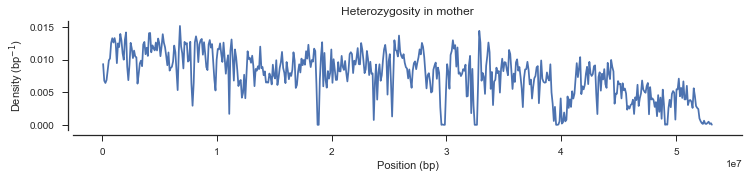

In [28]:
plot_density(pos_cross_pass[genotypes_cross_pass[:, 0].is_het()],
             title='Heterozygosity in mother')

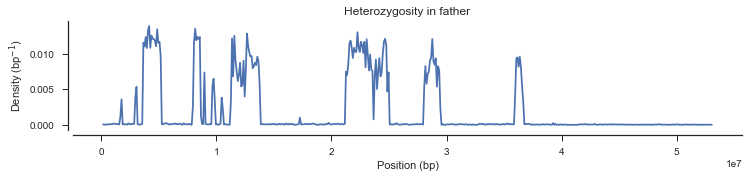

In [29]:
plot_density(pos_cross_pass[genotypes_cross_pass[:, 1].is_het()],
             title='Heterozygosity in father')

## Mendelian errors

Another thing you can do with genotype calls from a cross is to look for calls in one or more progeny that are not consistent with Mendelian transmission, also known as Mendelian errors. Let's locate Mendelian errors using the [`mendel_errors()`](http://scikit-allel.readthedocs.io/en/latest/stats/mendel.html#allel.stats.mendel.mendel_errors) function. We'll run this on a different set of calls, again keeping only variants that segregate within the cross, but this time we won't exclude SNPs that didn't pass quality filters. 

In [30]:
genotypes_cross = genotypes.subset(loc_seg, sample_indices)
genotypes_cross

<GenotypeChunkedArray shape=(2142258, 22, 2) dtype=int8 chunks=(8369, 22, 2)
   nbytes=89.9M cbytes=25.1M cratio=3.6
   compression=blosc compression_opts={'clevel': 5, 'shuffle': 1, 'cname': 'lz4'}
   values=zarr.core.Array>

In [31]:
genotypes_parents = genotypes_cross[:, :2]
genotypes_progeny = genotypes_cross[:, 2:]
mendel_errors = allel.mendel_errors(genotypes_parents, genotypes_progeny)
mendel_errors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [32]:
mendel_errors.shape

(2142258, 20)

The `mendel_errors` array has one element for each progeny genotype call, and counts the number of non-Mendelian alleles present (up to 2). This can be summarized in various ways, e.g., by individual.

In [33]:
mendel_errors_by_sample = np.sum(mendel_errors, axis=0)
mendel_errors_by_sample

array([150437, 147810, 145152, 144064, 147128, 146949, 131825, 146373,
       128950, 148635, 138708, 142210, 145581, 135932, 139459, 136204,
       140298, 149186, 144172, 139478])

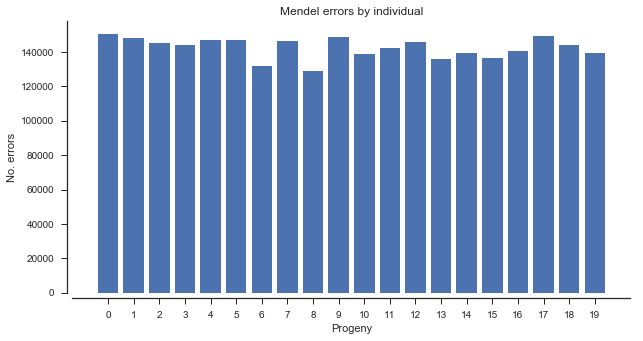

In [34]:
# plot errors by sample
fig, ax = plt.subplots(figsize=(10, 5))
sns.despine(ax=ax, offset=5)
left = list(range(len(mendel_errors_by_sample)))
height = mendel_errors_by_sample
ax.bar(left, height)
ax.set_xticks(left)
ax.set_xlabel('Progeny')
ax.set_ylabel('No. errors')
ax.set_title('Mendel errors by individual');

We could also look at the density of Mendel errors over the genome.

In [35]:
mendel_errors_by_variant = np.sum(mendel_errors, axis=1)
mendel_errors_by_variant

array([ 1, 10,  5, ...,  0,  0,  0])

In [36]:
pos_cross = pos[loc_seg]

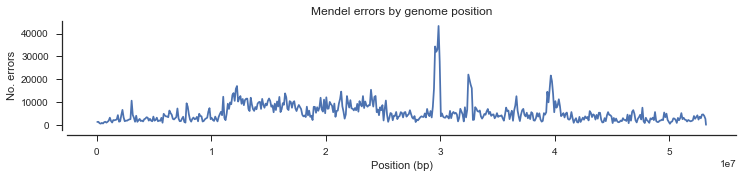

In [37]:
fig, ax = plt.subplots(figsize=(12, 2))
sns.despine(ax=ax, offset=5)
y, windows, _ = allel.windowed_statistic(pos_cross, values=mendel_errors_by_variant, statistic=np.sum, size=100000)
x = np.mean(windows, axis=1)
ax.plot(x, y)
ax.set_xlabel('Position (bp)')
ax.set_ylabel('No. errors')
ax.set_title('Mendel errors by genome position');

Another analysis we can do is to study the association between rate of Mendel error and variant annotations like QD (quality by depth) and MQ (mapping quality). This can be useful when designing a variant filtering strategy.

In [38]:
# load some variant annotations
vtbl = allel.VariantChunkedTable(callset['3R/variants'], names=['POS', 'QD', 'MQ'])
# subset annotations to sites segregating in the cross
vtbl_cross = vtbl.compress(loc_seg)[:]
vtbl_cross

<VariantTable shape=(2142258,) dtype=(numpy.record, [('POS', '<i4'), ('QD', '<f2'), ('MQ', '<f2')])>
[(13, 22.734375, 51.5) (66, 1.3203125, 51.625)
 (94, 0.280029296875, 51.1875) ...,
 (53200369, 0.01000213623046875, 14.046875)
 (53200391, 0.7001953125, 10.609375) (53200396, 0.68017578125, 9.7734375)]

In [39]:
def plot_variant_me(f, bins):

    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=5)
    x = vtbl_cross[f]

    # plot a histogram
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')

    # plot Mendel errors
    ax = ax.twinx()
    sns.despine(ax=ax, bottom=True, left=True, right=False, offset=10)
    values = mendel_errors_by_variant
    with np.errstate(over='ignore'):
        # binned_statistic generates an annoying overflow warning which we can ignore
        y1, _, _ = scipy.stats.binned_statistic(x, values, statistic=np.mean, bins=bins)
    bx = (bins[1:] + bins[:-1]) / 2
    ax.plot(bx, y1, color='k', label='Mendel errors')
    ax.set_ylabel('Mendel error rate')
    ax.legend(loc='upper right')


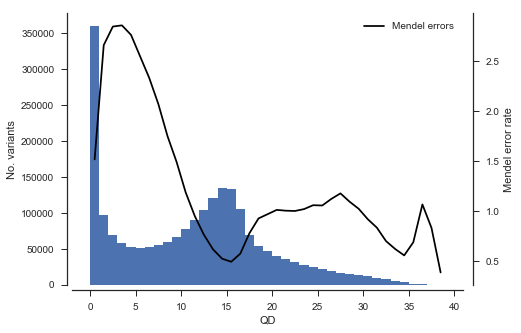

In [40]:
plot_variant_me('QD', bins=np.arange(0, 40, 1))

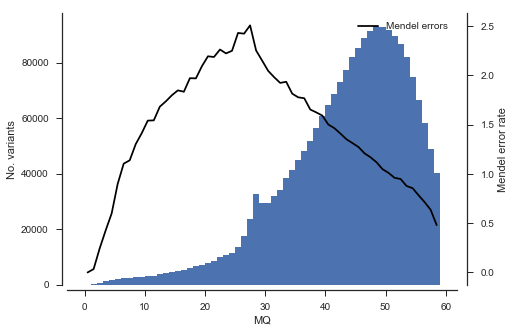

In [41]:
plot_variant_me('MQ', bins=np.arange(0, 60, 1))

In [42]:
def plot_joint_variant_me(f1, f2, gridsize=20, mincnt=20, extent=None):
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=5)
    x = vtbl_cross[f1]
    y = vtbl_cross[f2]
    C = mendel_errors_by_variant
    im = ax.hexbin(x, y, C=C, reduce_C_function=np.mean, mincnt=mincnt, extent=extent,
                   gridsize=gridsize, cmap='jet')
    fig.colorbar(im)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s and Mendel error rate' % (f1, f2))

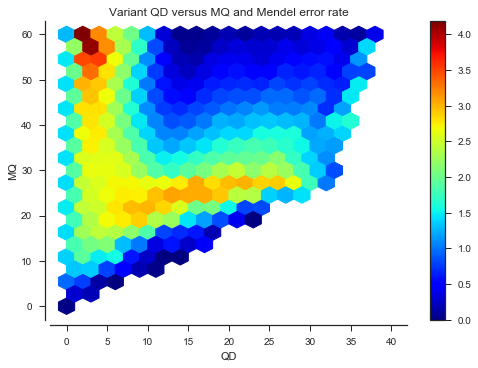

In [43]:
plot_joint_variant_me('QD', 'MQ', extent=(0, 40, 0, 60))

## Further reading

* [scikit-allel API docs](http://scikit-allel.readthedocs.io/en/latest/stats/mendel.html) (Mendelian inheritance module)
* J. O'Connell et al. (2013) A general approach for haplotype phasing across the full spectrum of relatedness. PLoS Genetics. 10(4) [doi:10.1371/journal.pgen.1004234](http://www.plosgenetics.org/article/info%3Adoi%2F10.1371%2Fjournal.pgen.1004234) 
* [MERLIN tutorial](http://csg.sph.umich.edu/abecasis/merlin/tour/haplotyping.html)